In [26]:
import torch
import numpy as np
from scipy import ndimage
import model
import tools
import time
import eval
from sklearn import metrics
from progress.bar import Bar

import matplotlib.pyplot as plt

In [104]:
def cluster(grid):
    grid = grid.reshape(300, 400)
    grid = grid.astype(np.int32)
    return ndimage.label(grid, structure=np.ones((3, 3)))

def get_frame(data, frame_no, pivot):
    return data.train_x[frame_no], data.train_y[frame_no]

def show(frame):
    frame = frame.reshape(300, 400)
    plt.imshow(frame)
    
def predict(model, x):
    x = x.reshape(-1, 1, 300, 400)
    x = tools.make_cpu(x)
    return model(x)

def show_all(x, y, pred_y, labelled):
    x = x.reshape(300, 400)
    pred_y = pred_y.reshape(300, 400)
    y = y.reshape(300, 400)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    valid_true_inds = (x > 0) & (labelled > 0)
    labelled[~valid_true_inds] = 0
    
    ax1.imshow(x, cmap='tab20b')
    ax1.set_title("True clusters (Grid 2D)")
    ax2.imshow(labelled, cmap='tab20b')
    ax2.set_title("Predicted clusters (CCA)")
    
    ax3.imshow(y, cmap='tab20b')
    ax3.set_title("Expected autoencoder output (Convex hulls)")
    ax4.imshow(pred_y, cmap='gray')
    ax4.set_title("Autencoder output (Convex hulls)")
    
    plt.savefig("example_1.png")
    
def extract_no_clusters(grid):
    # -1 because it returns 0 as well
    return len(np.unique(grid) - 1)

def extract_labels(true_grid, predicted_grid):
    valid_inds = np.where((true_grid > 0) & (predicted_grid > 0))
    true_labels = true_grid[valid_inds]
    predicted_labels = predicted_grid[valid_inds]
    return true_labels, predicted_labels

def stats(name, data):
    print("\n============ {} ============".format(name))
    print("Mean: {}".format(np.mean(data)))
    print("Std: {}".format(np.mean(data)))
    q = [x for x in np.linspace(0, 100, 21)]
    percentiles = np.percentile(data, q=q)
    print("Percentiles:")
    for i, p in zip(q, percentiles):
        print("{}%:{:.3f}".format(i, p))


In [3]:
# load data
data = tools.DataLoader("../autencoder/convex_hulls.npy")


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  38.  40.  41.  42.  43.  44.]


In [4]:
# create model
autencoder_weights = torch.load("conv_autoencoder.pth", map_location=lambda storage, loc: storage)
autencoder = model.AutoEncoder()
autencoder.load_state_dict(autencoder_weights)

In [105]:
def get_score_for_frame(data, frame_no, threshold=0.9, visualize=False):
    # visualize results
    x, y = get_frame(data, frame_no, 0)
    x = x.reshape(300, 400)
    py = predict(autencoder, data.normalize(x.copy()))


    py = tools.make_numpy(py)
    py[py >= threshold] = 255
    py[py < threshold] = 0
    labelled, _ = cluster(py)

    if visualize:
        show_all(x, y, py, labelled)

    true_labels, predicted_labels = extract_labels(x, labelled)
    no_true_labels = len(np.unique(true_labels))
    no_pred_labels = len(np.unique(predicted_labels))
    score = metrics.adjusted_rand_score(true_labels, predicted_labels)
    
    return score, no_true_labels, no_pred_labels




Score: 0.9996309780146917
TC = 13, PC = 17


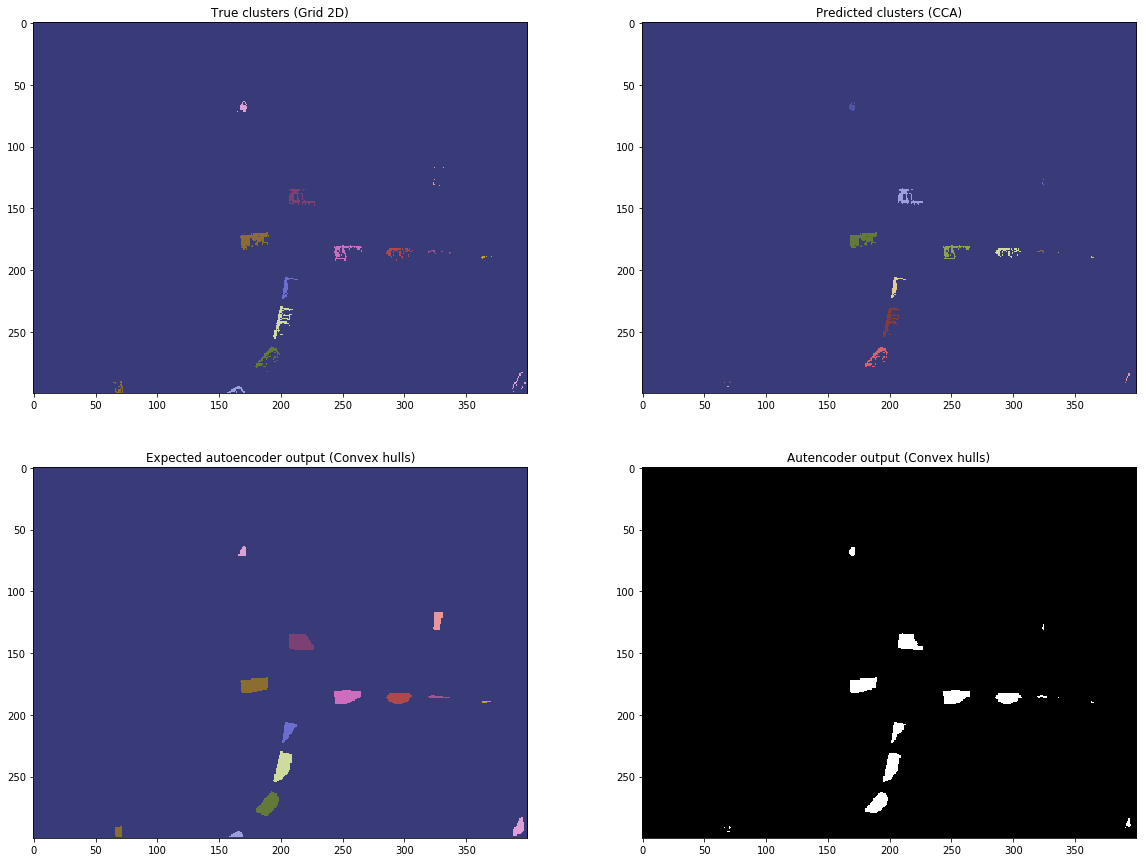

In [107]:
score, no_true_labels, no_pred_labels = get_score_for_frame(data, 301, visualize=True)
print("Score: {}".format(score))
print("TC = {}, PC = {}".format(no_true_labels, no_pred_labels))

In [97]:
scores = []
tcs = []
pcs = []

progress = Bar("Evaluation", max=len(data.valid_x))
for frame_no in range(0, len(data.valid_x)):
    progress.next()
    score, tc, pc = get_score_for_frame(data, frame_no, threshold=0.9)
    scores.append(score)
    tcs.append(tc)
    pcs.append(pc)
    if (frame_no + 1) % 100 == 0:
        print(frame_no)
    
progress.finish()

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199
4299
4399
4499


In [98]:
stats("Score", scores)


============ Score ============
Mean: 0.9593069903293245
Std: 0.9593069903293245
Percentiles:
0.0%:0.000
5.0%:0.782
10.0%:0.891
15.0%:0.935
20.0%:0.968
25.0%:0.987
30.0%:0.995
35.0%:0.997
40.0%:1.000
45.0%:1.000
50.0%:1.000
55.0%:1.000
60.0%:1.000
65.0%:1.000
70.0%:1.000
75.0%:1.000
80.0%:1.000
85.0%:1.000
90.0%:1.000
95.0%:1.000
100.0%:1.000


In [99]:
stats("TC - PC", np.array(tcs) - np.array(pcs))


============ TC - PC ============
Mean: -0.2178894029521921
Std: -0.2178894029521921
Percentiles:
0.0%:-8.000
5.0%:-2.000
10.0%:-1.000
15.0%:-1.000
20.0%:-1.000
25.0%:-1.000
30.0%:0.000
35.0%:0.000
40.0%:0.000
45.0%:0.000
50.0%:0.000
55.0%:0.000
60.0%:0.000
65.0%:0.000
70.0%:0.000
75.0%:0.000
80.0%:0.000
85.0%:0.000
90.0%:0.000
95.0%:1.000
100.0%:4.000
